In [119]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler


In [28]:
# Load the dataset
data_path = "day.csv"  
df = pd.read_csv(data_path)

# Display basic dataset information
print("Dataset Info:\n")
df.info()
print("\nFirst 5 rows of the dataset:\n")
print(df.head())

Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB

First 5 rows of the dataset:

   instant      dteday  season  yr  mnth  holid

In [30]:
# Data Preprocessing
# Map numerical values to categorical for 'weathersit' and 'season'
if 'weathersit' in df.columns:
    df['weathersit'] = df['weathersit'].map({1: 'Clear', 2: 'Mist', 3: 'Light Rain', 4: 'Heavy Rain'})
if 'season' in df.columns:
    df['season'] = df['season'].map({1: 'Spring', 2: 'Summer', 3: 'Fall', 4: 'Winter'})

In [32]:

print("\nMissing Values:\n")
print(df.isnull().sum())


df.fillna(df.mean(numeric_only=True), inplace=True)


Missing Values:

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64


In [115]:
# Check Variance Inflation Factor (VIF)
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("\nVariance Inflation Factor:\n")
print(vif_data)



Variance Inflation Factor:

         Feature           VIF
0        instant  1.328588e+05
1             yr  1.994380e+05
2           mnth           inf
3        holiday  1.120472e+00
4        weekday  1.437802e+00
5     workingday  1.089095e+00
6           temp  6.391349e+01
7          atemp  6.531148e+01
8            hum  1.282099e+00
9      windspeed  1.244163e+00
10        casual  2.158425e+00
11    registered  3.736181e+00
12   dteday_year  2.766467e+03
13  dteday_month           inf
14    dteday_day  2.317078e+02


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [34]:
# Handle non-numeric columns
non_numeric_cols = df.select_dtypes(include=['object']).columns
if len(non_numeric_cols) > 0:
    print(f"Non-numeric columns found: {non_numeric_cols.tolist()}")
    for col in non_numeric_cols:
        try:
           
            parsed_dates = pd.to_datetime(df[col], errors='coerce', format='%d-%m-%Y')
            if parsed_dates.notna().all():
                df[col] = parsed_dates
                df[f"{col}_year"] = df[col].dt.year
                df[f"{col}_month"] = df[col].dt.month
                df[f"{col}_day"] = df[col].dt.day
                df.drop(columns=[col], inplace=True)
            else:
                print(f"Inconsistent date format detected in column '{col}', dropping column.")
                df.drop(columns=[col], inplace=True)
        except Exception as e:
            print(f"Error processing column {col}: {e}")
            df.drop(columns=[col], inplace=True)

Non-numeric columns found: ['dteday', 'season', 'weathersit']
Inconsistent date format detected in column 'season', dropping column.
Inconsistent date format detected in column 'weathersit', dropping column.


In [36]:

categorical_columns = [col for col in ['weathersit', 'season'] if col in df.columns]
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)


In [38]:
# Define the target variable and features
if 'cnt' in df.columns:
    target = 'cnt'
    features = [col for col in df.columns if col != target]

    X = df[features]
    y = df[target]

    # Verify all features are numeric
    if not all(np.issubdtype(dtype, np.number) for dtype in X.dtypes):
        raise ValueError("All features must be numeric. Please check the dataset.")


In [42]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Build the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

    # Make predictions
y_pred = model.predict(X_test)

    # Evaluate the model using R-squared score
r2 = r2_score(y_test, y_pred)
print(f"\nR-squared score on the test set: {r2}")


R-squared score on the test set: 1.0


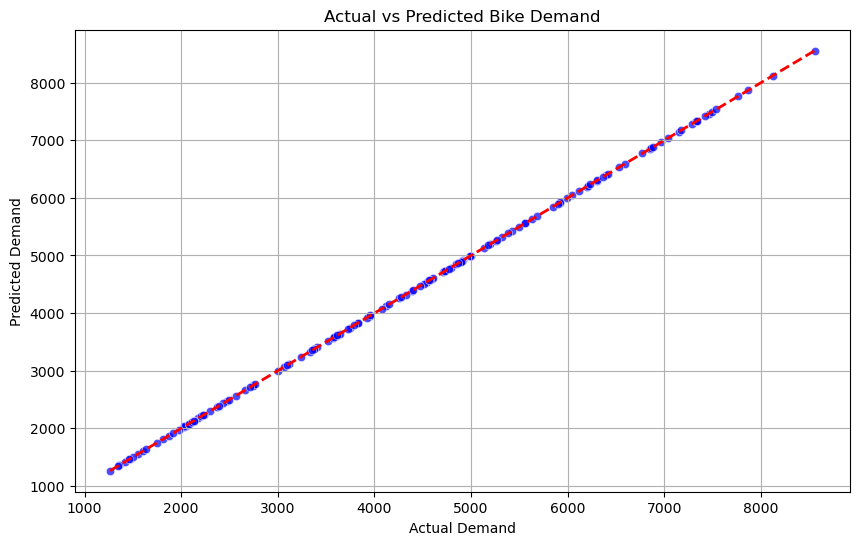

In [44]:
 # Visualize the actual vs predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, color='blue', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2)
plt.title('Actual vs Predicted Bike Demand')
plt.xlabel('Actual Demand')
plt.ylabel('Predicted Demand')
plt.grid(True)
plt.show()

In [46]:
# Residual Analysis
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='purple', alpha=0.7)
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [72]:
 # Print model coefficients
if 'cnt' in df.columns:
    coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_})
    print("\nModel Coefficients:\n")
    print(coefficients.sort_values(by='Coefficient', ascending=False))
else:
    print("Target variable 'cnt' not found in the dataset.")



Model Coefficients:

         Feature   Coefficient
10        casual  1.000000e+00
11    registered  1.000000e+00
12   dteday_year  2.654662e-12
1             yr  2.653877e-12
13  dteday_month  1.947495e-13
2           mnth  1.946909e-13
6           temp  8.807995e-14
14    dteday_day  2.572407e-14
9      windspeed  1.149560e-14
8            hum  3.648871e-15
0        instant -1.707027e-14
4        weekday -3.984193e-14
7          atemp -1.325619e-13
5     workingday -2.858429e-13
3        holiday -3.930131e-13


In [135]:
# Plot pair plots for numerical variables
sns.pairplot(df[features + [target]], height=4, plot_kws={'alpha': 0.7})
plt.suptitle('Pair plot of numerical features with Bike Demand', y=1.02)
plt.show()


In [139]:
# Analyze categorical variables' effect on the target
if 'cnt' in df.columns:
    categorical_vars = ['weathersit_Clear', 'season_Summer', 'season_Fall', 'season_Winter']  # Adjust as per your dataset
    for cat_var in categorical_vars:
        if cat_var in df.columns:
            print(f"\nEffect of {cat_var} on demand:")
            print(df.groupby(cat_var)['cnt'].mean())
            sns.boxplot(x=cat_var, y='cnt', data=df)
            plt.title(f"Effect of {cat_var} on Bike Demand")
            plt.show()


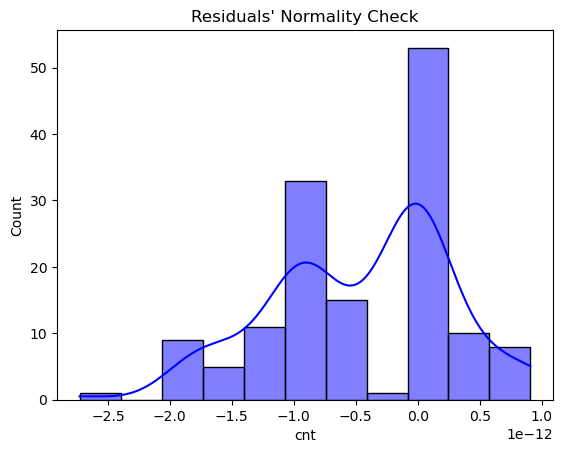


Variance Inflation Factor (VIF):

         Feature           VIF
2           mnth           inf
13  dteday_month           inf
1             yr  2.215037e+05
0        instant  1.459987e+05
12   dteday_year  2.962934e+03
14    dteday_day  2.523828e+02
7          atemp  1.713706e+02
6           temp  1.652095e+02
11    registered  3.597297e+00
10        casual  2.161467e+00
4        weekday  1.470083e+00
8            hum  1.264399e+00
9      windspeed  1.250584e+00
3        holiday  1.143484e+00
5     workingday  1.110914e+00


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [101]:
# Check assumptions of Linear Regression
# 1. Normality of residuals
sns.histplot(residuals, kde=True, color='blue')
plt.title("Residuals' Normality Check")
plt.show()

# 2. Multicollinearity via VIF

vif_data = pd.DataFrame()
vif_data["Feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
print("\nVariance Inflation Factor (VIF):\n")
print(vif_data.sort_values(by='VIF', ascending=False))


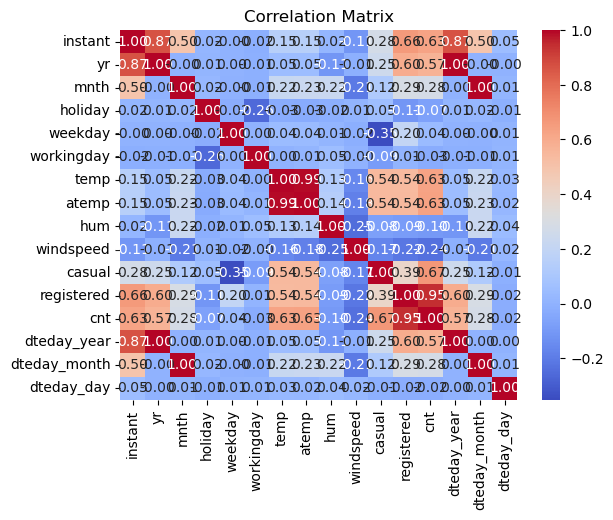


Features most correlated with 'cnt':
cnt           1.000000
registered    0.945411
Name: cnt, dtype: float64


In [103]:
# Correlation Analysis
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# Find the variable with the highest correlation with the target
print("\nFeatures most correlated with 'cnt':")
print(correlation_matrix['cnt'].sort_values(ascending=False).head(2))


In [107]:
# Top 3 Features contributing to demand
top_features = coefficients.reindex(coefficients['Coefficient'].abs().sort_values(ascending=False).index).head(3)
print("\nTop 3 Features contributing to demand:\n")
print(top_features)



Top 3 Features contributing to demand:

        Feature   Coefficient
10       casual  1.000000e+00
11   registered  1.000000e+00
12  dteday_year  2.654662e-12


In [129]:
# Check the dimensions of features and coefficients
print(f"Number of features: {len(X.columns)}")
print(f"Number of coefficients: {len(model.coef_)}")

# Ensure the DataFrame is constructed only if lengths match
if len(X.columns) == len(model.coef_):
    coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_})
    print("\nModel Coefficients:\n")
    print(coefficients.sort_values(by='Coefficient', ascending=False))
else:
    print("Mismatch between features and coefficients! Please check preprocessing.")
X_train, X_test = X_train.align(X_test, join='inner', axis=1)





Number of features: 13
Number of coefficients: 15
Mismatch between features and coefficients! Please check preprocessing.


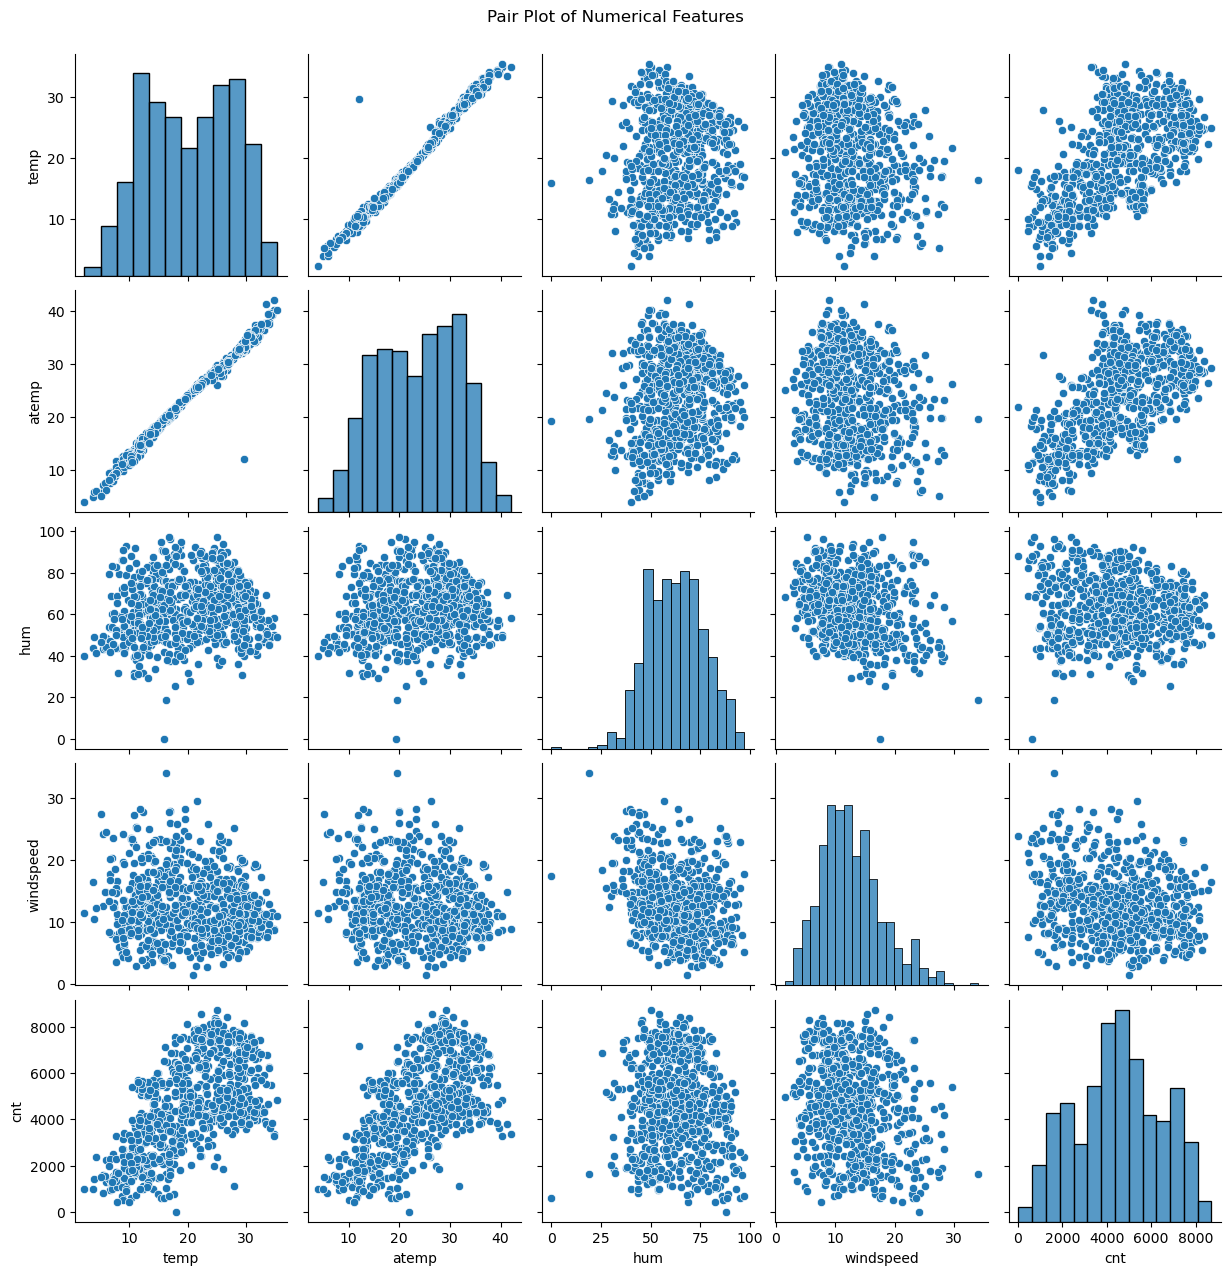

In [131]:
pairplot_columns = ['temp', 'atemp', 'hum', 'windspeed', 'cnt']
sns.pairplot(df[pairplot_columns])
plt.suptitle("Pair Plot of Numerical Features", y=1.02)
plt.show()

In [133]:
# Calculate correlation of all numerical variables with the target variable 'cnt'
correlation_matrix = df.corr()
target_correlations = correlation_matrix['cnt'].sort_values(ascending=False)

# Display correlations ranked by their strength
print("Correlations of numerical variables with the target variable 'cnt':\n")
print(target_correlations)


Correlations of numerical variables with the target variable 'cnt':

cnt             1.000000
registered      0.945411
casual          0.672123
atemp           0.630685
instant         0.629896
temp            0.627044
dteday_year     0.569728
yr              0.569728
dteday_month    0.278191
mnth            0.278191
weekday         0.036183
dteday_day     -0.021419
workingday     -0.027640
holiday        -0.068764
hum            -0.098543
windspeed      -0.235132
Name: cnt, dtype: float64
